# Payload Identifier 

## Using Deep Learning to classify API attacks



# Installing dependencies and data

In [ ]:
# !pip3 install -q tensorflow_gpu=
# !pip install --upgrade tensorflow
!pip install tensorflow==2.1

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [ ]:
!pip3 install gast==0.3.2

In [ ]:
!pip3 install -q ktrain


     |████████████████████████████████| 25.2MB 129kB/s 
     |████████████████████████████████| 421.8MB 16kB/s 
     |████████████████████████████████| 6.7MB 59.4MB/s 
     |████████████████████████████████| 983kB 40.0MB/s 
     |████████████████████████████████| 245kB 45.8MB/s 
     |████████████████████████████████| 675kB 44.3MB/s 
     |████████████████████████████████| 471kB 42.2MB/s 
     |████████████████████████████████| 450kB 45.9MB/s 
     |████████████████████████████████| 3.9MB 46.8MB/s 
     |████████████████████████████████| 890kB 37.0MB/s 
     |████████████████████████████████| 3.8MB 43.4MB/s 
     |████████████████████████████████| 1.1MB 47.1MB/s 
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [ ]:
import ktrain
print(ktrain.__version__)

0.16.2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load the dataset


In [ ]:
import sys
import os
import random

In [ ]:
LABELS = {}
INV_LABELS = {}
for i, label in enumerate(os.listdir('gdrive/My Drive/datasets-payload-identifier/')):
  LABELS[i] = label
  INV_LABELS[label] = i

In [ ]:
from sklearn.model_selection import train_test_split
dataset_size = {}
target_names = []

def get_dataset(path, test_size=0.25, random_state=42):
  X = []
  Y = []
  for label in os.listdir(path):
    target_names.append(label)
    with open(os.path.join('gdrive/My Drive/datasets-payload-identifier/', label, 'ALL_FILES.txt')) as f:
      lines = f.readlines()
      dataset_size[label] = len(lines)
      for payload in lines:
        if("\n" in payload):
          X.append(payload.replace("\n", ""))
          Y.append(INV_LABELS[label])
          
  return train_test_split(X, Y, test_size=test_size, random_state=random_state)

x_train, x_test, y_train, y_test = get_dataset('gdrive/My Drive/datasets-payload-identifier/')

In [ ]:
count = 1
for i in y_test:
  if(LABELS[i] == ''):
    count+=1

print(count)

2010


Dataset size: 
Payload: xxe - Size: 115
Payload: path-traversal - Size: 7090
Payload: xss - Size: 9882
Payload: file-inclusion - Size: 7935
Payload: credentials - Size: 6702
Payload: sql - Size: 3550
Payload: email - Size: 7996
Payload: rce - Size: 1036


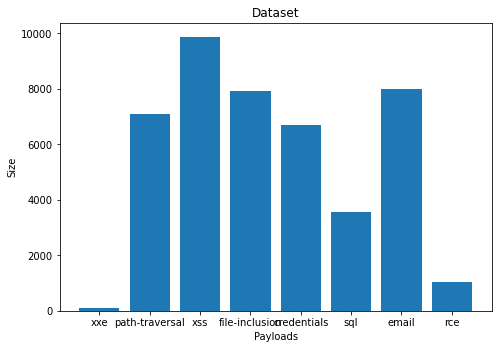

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = plt.figure().add_axes([0,0,1,1])
print("Dataset size: ")
for k, v in dataset_size.items():
  print("Payload: {} - Size: {}".format(k, v))
payloads = dataset_size.keys()
size = dataset_size.values()
ax.bar(payloads, size)
plt.title("Dataset")
plt.xlabel("Payloads")
plt.ylabel("Size")
plt.show()

# Create the model


In [ ]:
import ktrain
from ktrain import text
# distillbert - roberta - xlm - albert - bert

#MODELS = ['bert-base-uncased', 'distilbert-base-uncased', 'roberta-large', 'xlm-roberta-base', 'albert-base-v2']
MODEL_NAME = 'distilbert-base-uncased'
#for MODEL_NAME in MODELS:
print("Running model: ".upper(), MODEL_NAME.upper())
print("\n\n\n")
t = text.Transformer(MODEL_NAME, maxlen=500, classes=target_names)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
learner.fit_onecycle(5e-5, 1)
print("Validating: ")
learner.validate(class_names=t.get_classes())
print("Top losses: ")
learner.view_top_losses(preproc=t)
#print("Confusion Matrix: ")
#predictor = ktrain.get_predictor(learner.model, preproc=t)
#predictor.analyze_valid((x_test, y_test))
print("Finished running model: ", MODEL_NAME)


RUNNING MODEL:  DISTILBERT-BASE-UNCASED






/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:367: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: en
train sequence lengths:
	mean : 2
	95percentile : 5
	99percentile : 10


preprocessing test...
language: en
test sequence lengths:
	mean : 2
	95percentile : 5
	99percentile : 9




begin training using onecycle policy with max lr of 5e-05...
Train for 5538 steps, validate for 347 steps
5538/5538 [==============================] - 1425s 257ms/step - loss: 0.1665 - accuracy: 0.9596 - val_loss: 0.0491 - val_accuracy: 0.9855
Validating: 
                precision    recall  f1-score   support

           xxe       0.95      0.71      0.82        28
path-traversal       0.99      0.96      0.98      1831
           xss       1.00      1.00      1.00      2467
file-inclusion       0.96      0.99      0.98      1947
   credentials       0.99      0.99      0.99      1656
           sql       0.98      0.98      0.98       880
         email       1.00      1.00      1.00      2009
           rce       0.94      0.93      0.93       257

      accuracy                           0.99     11075
     macro avg       0.98      0.95      0.96     11075
  weighted avg       0.99      0.99      0.99     11075

Top losses: 
----------
id:6149 | loss:9.09 | true:xxe | pred:sql)

# Predicting new payloads

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
predictor.predict(";wget 192.168.1.1 -c -a;ping 12313;")

'rce'

In [ ]:
predictor.predict_proba(";wget 192.168.1.1 -c -a;ping 12313;")


array([9.49885987e-04, 3.35088174e-04, 2.64028879e-03, 1.36631366e-03,
       3.13900970e-03, 7.95728900e-03, 1.02633625e-04, 9.83509600e-01],
      dtype=float32)

In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [ ]:
predictor.explain(testes[0])

In [ ]:
predictor.explain(testes[5])


In [ ]:
predictor.explain(testes[10])


In [ ]:
predictor.explain(testes[8])


# Saving the model


In [ ]:
predictor.save('distilbert-base-uncased-FINAL')

# Loading model

In [ ]:
reloaded_predictor = ktrain.load_predictor('gdrive/My Drive/BERT-TCC/distilbert-base-uncased-FINAL')

# Testing against anti-WAF


In [ ]:
testes  = ["' or 1¼1-- ' or 2¼2--", "' or 1¼1-- '¼'", '";alert(0);" "*alert(0)*"', "',alert(0),b' '%0aalert(0)%0a'", 
           'alert(0) %00alert(0)', '<script>alert(0)</script> <script type¼vbscript>MsgBox(0)', '</script>', '\' OR ""¼\' \'/**/OR/**/""¼\'', 
           "' union select 1;-- ' union all select 1;--", '<script>alert(0)</script> <SCRIPT>alert(0)</SCRIPT>', 
           '<script>alert(0)</script> <img src¼"x:x" onerror¼"alert(0)">', '</img>', '<img src¼"x:x"', 'onerror¼"alert(0)">', '</img>',
           '<img src¼"x:x" onerror¼"alert(0)">', '</img>', "<img src¼'x:x'","onerror¼'alert(0)'></img>", '<img src¼x:x onerror¼alert(0)//>',
           '</img>', '<img src¼x:x onerror¼alert', '(0)//></img>', '<img src¼http://0x.lv/ onload¼', 'alert(0)//></img>', '<img src¼http://0x.lv/',
           'onload¼alert(0)//></img>', '<marquee onstart¼alert(0)//>', '1 or 1¼1 (1)or(1)¼(1)', 'alert(0) deletetypeoftypeoftypeoftypeof', 'typeof',
           'typeofalert(0)', 'eval(name) x¼this.name', 'x(0?$:name+1)', "2a''-1 ^''0 2a''-1 ^ ' 0''' and (select mid(user,", "1 /1,1/ 1)from'mysql'.user limit 1)", 
           "rlike ''r", 'xyz¼this', 'zyx¼xyz[1].alert', 'zyx(1)', 'xyz¼Iterator([this]).next()', 'zyx¼xyz[1].alert', 'zyx(1)']
for exploit in testes:
  print(exploit, " >>> ", reloaded_predictor.predict(exploit))

' or 1¼1-- ' or 2¼2--  >>>  sql


' or 1¼1-- '¼'  >>>  sql


";alert(0);" "*alert(0)*"  >>>  xss


',alert(0),b' '%0aalert(0)%0a'  >>>  sql


alert(0) %00alert(0)  >>>  xss


<script>alert(0)</script> <script type¼vbscript>MsgBox(0)  >>>  xss


</script>  >>>  xss


' OR ""¼' '/**/OR/**/""¼'  >>>  sql


' union select 1;-- ' union all select 1;--  >>>  sql


<script>alert(0)</script> <SCRIPT>alert(0)</SCRIPT>  >>>  xss


<script>alert(0)</script> <img src¼"x:x" onerror¼"alert(0)">  >>>  xss


</img>  >>>  xss


<img src¼"x:x"  >>>  xss


onerror¼"alert(0)">  >>>  xss


</img>  >>>  xss


<img src¼"x:x" onerror¼"alert(0)">  >>>  xss


</img>  >>>  xss


<img src¼'x:x'  >>>  xss


onerror¼'alert(0)'></img>  >>>  xss


<img src¼x:x onerror¼alert(0)//>  >>>  xss


</img>  >>>  xss


<img src¼x:x onerror¼alert  >>>  xss


(0)//></img>  >>>  sql


<img src¼http://0x.lv/ onload¼  >>>  xss


alert(0)//></img>  >>>  xss


<img src¼http://0x.lv/  >>>  xss


onload¼alert(0)//></img>  >>>  xss


<marquee onstart¼alert(0)//>  >>>  xss


1 or 1¼1 (1)or(1)¼(1)  >>>  sql


alert(0) deletetypeoftypeoftypeoftypeof  >>>  xss


typeof  >>>  credentials


typeofalert(0)  >>>  xss


eval(name) x¼this.name  >>>  rce


x(0?$:name+1)  >>>  sql


2a''-1 ^''0 2a''-1 ^ ' 0''' and (select mid(user,  >>>  sql


1 /1,1/ 1)from'mysql'.user limit 1)  >>>  sql


rlike ''r  >>>  sql


xyz¼this  >>>  credentials


zyx¼xyz[1].alert  >>>  xss


zyx(1)  >>>  xss


xyz¼Iterator([this]).next()  >>>  xss


zyx¼xyz[1].alert  >>>  xss


zyx(1)  >>>  xss


In [ ]:
# https://portswigger.net/web-security/cross-site-scripting/cheat-sheet
with open("gdrive/My Drive/BERT-TCC/xss_tests.txt", 'r') as f:
  xss_payloads = f.readlines()
xss_accuracy = 0
for payload in xss_payloads:
  if(reloaded_predictor.predict(payload)== 'xss'):
    xss_accuracy += 1
print("XSS lenght: {}".format(len(xss_payloads)))
print("XSS identified: {}".format(xss_accuracy))

XSS lenght: 8492
XSS identified: 8492


In [ ]:
# https://portswigger.net/web-security/sql-injection/cheat-sheet
with open("gdrive/My Drive/BERT-TCC/sql_tests.txt", 'r') as f:
  sql_payloads = f.readlines()
sql_accuracy = 0
for payload in sql_payloads:
  if(reloaded_predictor.predict(payload) == 'sql'):
    sql_accuracy += 1
print("sql lenght: {}".format(len(sql_payloads)))
print("sql identified: {}".format(sql_accuracy))
print('accuracy:', sql_accuracy*100/len(sql_payloads))

sql lenght: 51
sql identified: 45
accuracy: 88.23529411764706


In [ ]:
reloaded_predictor.explain("admin' or '1'='1'--")

In [ ]:
reloaded_predictor.explain("' union (select NULL, (select @@version)) --")

In [ ]:
reloaded_predictor.explain("AND (SELECT * FROM (SELECT(SLEEP(5)))bAKL) AND 'vRxe'='vRxe")

In [ ]:
reloaded_predictor.explain("<form action=javascript:alert(1)><input type=submit>")

In [ ]:
reloaded_predictor.explain("<svg id=alert(1) onload=eval(id)>")

In [ ]:
reloaded_predictor.explain("..%c0%qf..%c0%qf..%c0%qfetc%c0%qfissue")

In [ ]:
reloaded_predictor.explain("nc -lvvp 4446 -e /bin/sh|")

In [ ]:
reloaded_predictor.explain("%2 -n 21 127.0.0.1||`ping -c 21 127.0.0.1` #' |ping -n 21 127.0.0.1||`ping -c 21 127.0.0.1` #\" |ping -n 21 127.0.0.1")

In [ ]:
import numpy as np
reloaded_predictor.analyze_valid((x_test, y_test))

In [ ]:
reloaded_predictor.explain("/var/apache2/logs/access_log")

In [ ]:
reloaded_predictor.explain('<!DOCTYPE foo [<!ENTITY xxe7eb97 SYSTEM "file:///etc/passwd"> ]>')

In [ ]:
reloaded_predictor.explain('ZAQ!2wsx')

In [ ]:
reloaded_predictor.explain('tarcisio_marinho09@hotmail.com')